In [2]:
import math
import sys
import os

import torch
import torch.nn as nn
import torch.distributions as dist
import torch.nn.functional as F
import numpy as np
import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from models.critics import LinearModel,ASKLLayer
from mi_estimators import get_mi_estimator
from utils import make_critic_input, get_correlated_gaussian, mi_to_rho, mi_scheduler

%matplotlib inline
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
#Data params
GAUSSIAN_DIMS = 20

NITERS = 40000
BATCH_SIZE = 64

#Estimator Params
estimator_params = (
    {"mi_estimator":"nwj","clip":None,"name":"NWJ","lambda1":0.001,"lambda2":0.001},
    {"mi_estimator":"js","clip":None,"name":"JS","lambda1":0.00001,"lambda2":0.00001},
    {"mi_estimator":"mine","clip":None,"name":"MINE","lambda1":0.001,"lambda2":0.001},
    {"mi_estimator":"smile","clip":None,"name":"SMILE:$\infty$","lambda1":0.0001,"lambda2":0.001},
)

mi_true = mi_scheduler(NITERS)

In [4]:
#Training baselines
baseline_mis_all = []
LR = 5e-4
NF = 256
NLAYERS = 3
for params in estimator_params:
    MI_ESTIMATOR = params["mi_estimator"]
    mi_estimator = get_mi_estimator(MI_ESTIMATOR)()

    model = LinearModel(2*GAUSSIAN_DIMS,nf = NF, nlayers=NLAYERS).to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr = LR)
        
    model.train()
    
    mi_estimates = []
    
    for i in tqdm.tqdm(range(NITERS),desc=params["name"]):
        mi = mi_true[i]
        rho = mi_to_rho(GAUSSIAN_DIMS,mi)
        x,y = get_correlated_gaussian(rho,BATCH_SIZE,GAUSSIAN_DIMS)
        x,y = x.to(device),y.to(device)
        critic_inputs = make_critic_input(x,y)
        scores = model(critic_inputs).reshape([BATCH_SIZE,BATCH_SIZE])
        MI_estimate = mi_estimator(scores)
        loss = -1*MI_estimate

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        mi_estimates.append(MI_estimate.item())
    baseline_mis_all.append(mi_estimates)

SMILE:$\infty$: 100%|██████████| 40000/40000 [01:24<00:00, 471.92it/s]


In [5]:
STD1 = 0.1
STD2 = 0.1
STD3 = 1
LR = 1e-3
D = 512

askl_mis_all = []
for params in estimator_params:
    MI_ESTIMATOR = params["mi_estimator"]
    LAMBDA1 = params["lambda1"]
    LAMBDA2 = params["lambda2"]
    mi_estimator = get_mi_estimator(MI_ESTIMATOR)()
    askl_model = ASKLLayer(GAUSSIAN_DIMS*2,D).to(device)
    askl_model.init(STD1,STD2)
    W = nn.Parameter(torch.empty((D,1),device = device),requires_grad = True)
    torch.nn.init.normal_(W,0,STD3)
    optim = torch.optim.Adam(list(askl_model.parameters())+[W],LR)

    askl_model.train()
    mis = []
    for i in tqdm.tqdm(range(NITERS),desc=params["name"]):
        mi = mi_true[i]
        rho = mi_to_rho(GAUSSIAN_DIMS,mi)
        x,y = get_correlated_gaussian(rho,BATCH_SIZE,GAUSSIAN_DIMS)
        x = x.to(device)
        y = y.to(device)
        critic_inputs = make_critic_input(x,y)

        phi = askl_model(critic_inputs)
        critic_output = phi.mm(W)
        scores = critic_output.reshape([BATCH_SIZE,BATCH_SIZE])
        MI_estimate = mi_estimator(scores)

        W_norm = torch.norm(W,"fro")
        phi_fro_norm = torch.norm(phi,"fro")
        loss = -1*MI_estimate + LAMBDA1 * W_norm + LAMBDA2 * phi_fro_norm

        optim.zero_grad()
        loss.backward()
        optim.step()
        mis.append(MI_estimate.item())
    askl_mis_all.append(mis)

SMILE:$\infty$: 100%|██████████| 40000/40000 [02:00<00:00, 332.16it/s]


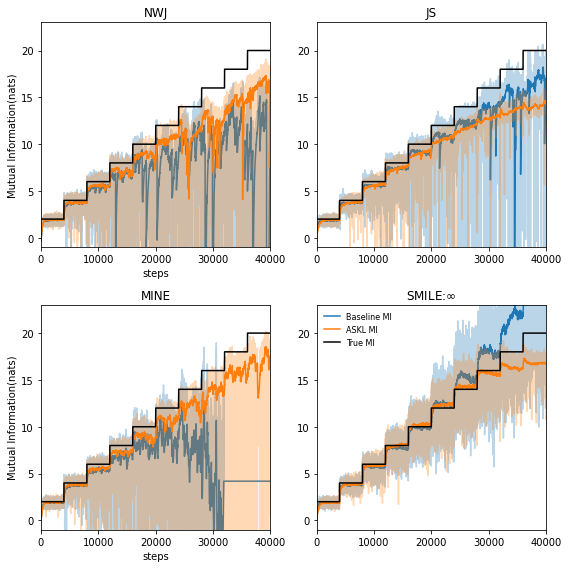

In [8]:
EMA = 200
nrows = 2
ncols = 2
fig,axs = plt.subplots(nrows,ncols,figsize=(4 * ncols, 4 * nrows))
axs = np.ravel(axs)

for i,(params,baseline_mis,askl_mis,axis) in enumerate(zip(estimator_params,baseline_mis_all,askl_mis_all,axs)):
    plt.sca(axis)
    baseline_mis_smooth = pd.Series(baseline_mis).ewm(span=EMA).mean()
    askl_mis_smooth = pd.Series(askl_mis).ewm(span=EMA).mean()
    p1 = plt.plot(baseline_mis, alpha=0.3)[0]
    plt.plot(baseline_mis_smooth, c=p1.get_color(),label="Baseline MI")
    p2 = plt.plot(askl_mis,alpha=0.3)[0]
    plt.plot(askl_mis_smooth,c=p2.get_color(),label="ASKL MI")
    plt.plot(mi_true, color='k',label="True MI")
    plt.ylim(-1,mi_true.max()+3)
    plt.xlim(0,NITERS)
    plt.title(params["name"])
    if i%ncols == 0:
        plt.xlabel("steps")
        plt.ylabel("Mutual Information(nats)")
plt.legend(loc="best",fontsize=8, framealpha=0.0)
plt.gcf().tight_layout()